In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_svmlight_file

In [2]:
X_train, y_train = load_svmlight_file("C:/Users/zhancongcong/Desktop/MLdata/a9a.txt")
X_test, y_test = load_svmlight_file("C:/Users/zhancongcong/Desktop/MLdata/a9a_test.txt",n_features=123)

In [3]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [4]:
print(X_train.shape)
print(X_test.shape)

(32561, 123)
(16281, 123)


In [5]:
X_train = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test = np.c_[np.ones((X_test.shape[0],1)),X_test]
print(X_train.shape)
print(X_test.shape)


(32561, 124)
(16281, 124)


NAG准确率为:
0.8474909403599288
RMSProp准确率为:
0.8485965235550642
AdaDelta准确率为:
0.8468767274737424
Adam准确率为:
0.8473066764940729


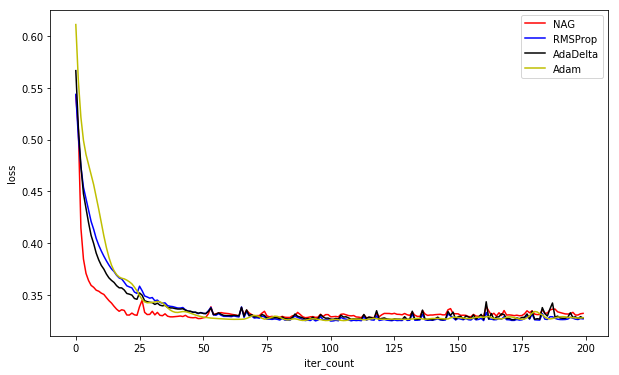

In [6]:
import random

def lg(samples, y, samples_t, y_t, max_iter_count=200):  #梯度下降
    #超参数
    step_size_nag=0.003
    r_nag=0.9
    
    step_size_rms=0.019
    r_rms=0.9
    
    r_adaDelta=0.95
    
    r_adam=0.95
    b_adam=0.9
    e_adam=0.025
    
    sample_num, dim = samples.shape
    sample_num_t, dim = samples_t.shape
    
    LOSS_T_NAG = [] 
    LOSS_T_RMS = [] 
    LOSS_T_ADADELTA = [] 
    LOSS_T_ADAM = []
    #NAG
    w_nag = np.zeros((dim,), dtype=np.float32)
    v_nag = np.zeros((dim,), dtype=np.float32)
    #RMSProp
    w_rms = np.zeros((dim,), dtype=np.float32)
    Gt_rms = np.zeros((dim,), dtype=np.float32)
    #AdaDelta
    w_adaDelta = np.zeros((dim,), dtype=np.float32)
    dt_adaDelta = np.zeros((dim,), dtype=np.float32)
    Gt_adaDelta = np.zeros((dim,), dtype=np.float32)
    #Adam
    w_adam = np.zeros((dim,), dtype=np.float32)
    Gt_adam = np.zeros((dim,), dtype=np.float32)
    mt_adam = np.zeros((dim,), dtype=np.float32)
    iter_count = 0
    
    while  iter_count < max_iter_count:
     
        loss_t_nag = 0
        loss_t_rms = 0
        loss_t_adaDelta = 0
        loss_t_adam = 0
              
        G_nag = np.zeros((dim,), dtype=np.float32) #NAG
        G_rms = np.zeros((dim,), dtype=np.float32) #RMSProp
        G_adaDelta = np.zeros((dim,), dtype=np.float32) #AdaDelta       
        G_adam = np.zeros((dim,), dtype=np.float32)#Adam
       
        
        index = random.randint(0, sample_num-1)         
        for i in range(300):
            i = (i+index)%sample_num
            #NAG
            w_x_nag = np.dot(w_nag-r_nag*v_nag, samples[i])
            y_w_x_nag = y[i] * w_x_nag
            #RMS
            w_x_rms = np.dot(w_rms, samples[i])
            y_w_x_rms = y[i] * w_x_rms
            #ADADELTA
            w_x_adaDelta = np.dot(w_adaDelta, samples[i])
            y_w_x_adaDelta = y[i] * w_x_adaDelta
            #ADAM
            w_x_adam = np.dot(w_adam, samples[i])
            y_w_x_adam = y[i] * w_x_adam
            for j in range(dim):                               
                                 
                G_nag[j] += -(samples[i][j]*y[i])/(1+np.e**y_w_x_nag) 
                G_rms[j] += -(samples[i][j]*y[i])/(1+np.e**y_w_x_rms)
                G_adaDelta[j] += -(samples[i][j]*y[i])/(1+np.e**y_w_x_adaDelta)
                G_adam[j] += -(samples[i][j]*y[i])/(1+np.e**y_w_x_adam)
        for j in range(dim):                      
            #NAG
            v_nag[j] = r_nag*v_nag[j]+ step_size_nag*G_nag[j]
            w_nag[j] -= v_nag[j]
            #RMS
            Gt_rms[j] = r_rms*Gt_rms[j]+(1-r_rms)*(G_rms[j]*G_rms[j])
            w_rms[j] = w_rms[j]-step_size_rms * G_rms[j]/np.sqrt(Gt_rms[j]+1e-4)  
            #ADADELTA
            Gt_adaDelta[j] = r_adaDelta*Gt_adaDelta[j]+(1-r_adaDelta)*(G_adaDelta[j]*G_adaDelta[j])
            ds = -np.sqrt(dt_adaDelta[j]+1e-4)*G_adaDelta[j]/np.sqrt(Gt_adaDelta[j]+1e-4) 
            w_adaDelta[j] += ds
            dt_adaDelta[j] = r_adaDelta*dt_adaDelta[j]+(1-r_adaDelta)*ds*ds
            #ADAM
            mt_adam[j] = b_adam*mt_adam[j]+(1-b_adam)*G_adam[j]
            Gt_adam[j] = r_adam*Gt_adam[j] + (1-r_adam)*G_adam[j]*G_adam[j]
            w_adam[j] = w_adam[j] - e_adam*np.sqrt(1-r_adam**(iter_count+1)
                                                  )/(1-b_adam**(iter_count+1))*mt_adam[j]/np.sqrt(Gt_adam[j]+1e-8)
        for i in range(sample_num_t):
            
            w_x_nag = np.dot(w_nag, samples_t[i])
            w_x_rms = np.dot(w_rms, samples_t[i])
            w_x_adaDelta = np.dot(w_adaDelta, samples_t[i])
            w_x_adam = np.dot(w_adam, samples_t[i])
            
            error_nag = np.log(1+np.e**(-y_t[i]*w_x_nag))
            error_rms = np.log(1+np.e**(-y_t[i]*w_x_rms))
            error_adaDelta = np.log(1+np.e**(-y_t[i]*w_x_adaDelta))
            error_adam = np.log(1+np.e**(-y_t[i]*w_x_adam))
            
            loss_t_nag += error_nag 
            loss_t_rms += error_rms
            loss_t_adaDelta += error_adaDelta 
            loss_t_adam += error_adam
            
        LOSS_T_NAG.append(loss_t_nag/sample_num_t) #NAG
        LOSS_T_RMS.append(loss_t_rms/sample_num_t) #RMAProp
        LOSS_T_ADADELTA.append(loss_t_adaDelta/sample_num_t)#AdaDelta
        LOSS_T_ADAM.append(loss_t_adam/sample_num_t)#Adam
        iter_count+=1;
    return w_nag,w_rms,w_adaDelta,w_adam,LOSS_T_NAG,LOSS_T_RMS,LOSS_T_ADADELTA,LOSS_T_ADAM
def accuracyRate(w):
    count = 0
    for i in range(X_test.shape[0]):
        w_x = np.dot(w, X_test[i])
        hx = 1/(1+np.e**(-w_x))
        if hx>=0.5 and y_test[i]==1:
            count+=1
        if hx<0.5 and y_test[i]==-1:
            count+=1    
    return count/X_test.shape[0]
    
import matplotlib.pyplot as plt
if __name__ == '__main__': 
    w_nag,w_rms,w_adaDelta,w_adam,LOSS_T_NAG,LOSS_T_RMS,LOSS_T_ADADELTA,LOSS_T_ADAM = lg(X_train, y_train, X_test, y_test)  
    print("NAG准确率为:") 
    print(accuracyRate(w_nag))   
    print("RMSProp准确率为:") 
    print(accuracyRate(w_rms))   
    print("AdaDelta准确率为:") 
    print(accuracyRate(w_adaDelta))
    print("Adam准确率为:")
    print(accuracyRate(w_adam))
    
    plt.figure(figsize=(10,6))     
    plt.plot( LOSS_T_NAG,  'r', label="NAG")
    plt.plot( LOSS_T_RMS, 'b', label="RMSProp")
    plt.plot(LOSS_T_ADADELTA, 'k', label="AdaDelta")
    plt.plot(LOSS_T_ADAM, 'y', label="Adam")
    plt.xlabel('iter_count')  
    plt.ylabel('loss')
    plt.legend()
    plt.show()